# Exploratory Data Analysis

## Generating master data
In this subsection I will depurate the database and form the "master data", a single .csv file containing all the relevant fields. This is very inefficient memory-wise, but eases plotting and selecting data drastically.

In [1]:
import pandas as pd

trips = pd.read_csv("datasets/Cab_Data.csv")
cities = pd.read_csv("datasets/City.csv", thousands=',')
customers = pd.read_csv("datasets/Customer_ID.csv")
transactions = pd.read_csv("datasets/Transaction_ID.csv")

master = pd.merge(pd.merge(trips, cities, on="City"),
                  pd.merge(customers, transactions, on="Customer ID"),
                  on="Transaction ID")

del trips, cities, customers, transactions
master

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Population,Users,Customer ID,Gender,Age,Income (USD/Month),Payment_Mode
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,814885,24701,29290,Male,28,10813,Card
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,814885,24701,27703,Male,27,9237,Card
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,814885,24701,28712,Male,53,11242,Cash
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.6020,814885,24701,28020,Male,23,23327,Cash
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.7760,814885,24701,27182,Male,33,8536,Card
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10440101,43108,Yellow Cab,WASHINGTON DC,4.80,69.24,63.3600,418859,127001,52392,Male,24,15651,Cash
359388,10440104,43104,Yellow Cab,WASHINGTON DC,8.40,113.75,106.8480,418859,127001,53286,Male,32,6528,Cash
359389,10440105,43105,Yellow Cab,WASHINGTON DC,27.75,437.07,349.6500,418859,127001,52265,Male,56,7966,Cash
359390,10440106,43105,Yellow Cab,WASHINGTON DC,8.80,146.19,114.0480,418859,127001,52175,Male,32,6423,Card


## Assumptions:
- The field "Cost of Trip" includes every possible expense, in such a way that the profit of a trip can be defined as the difference between its "Price Charged" and "Cost of Trip".
- The field "Date of Travel", whose values are integers, represents days; two adjacent integers represent two adjacent days and the lowest integer in the record corresponds to the starting date indicated in the assignment (31/01/2016).

## Univariate Analysis
In this section we will make a shallow analysis of the individual variables, focusing on the "main" fields, i.e. those in ```Cab_Data.csv```.

As a start, let's see how many missing values are present:

In [2]:
row_count = master.shape[0]
def bold(msg: str) -> str:
    return f"\033[1m{msg}\033[0m"

print(f"{bold('Number of entries:')} {row_count}")
print()
print(bold('Percentage of available entries per field:'))
print((100 * master.count()) // row_count)
print()
print(bold('Data types of each field:'))
print(master.dtypes)

Number of entries: 359392

Percentage of available entries per field:
Transaction ID        100
Date of Travel        100
Company               100
City                  100
KM Travelled          100
Price Charged         100
Cost of Trip          100
Population            100
Users                 100
Customer ID           100
Gender                100
Age                   100
Income (USD/Month)    100
Payment_Mode          100
dtype: int64

Data types of each field:
Transaction ID          int64
Date of Travel          int64
Company                object
City                   object
KM Travelled          float64
Price Charged         float64
Cost of Trip          float64
Population              int64
Users                   int64
Customer ID             int64
Gender                 object
Age                     int64
Income (USD/Month)      int64
Payment_Mode           object
dtype: object


On a first look all entries are completely filled. However, missing values might still be present in other poorly formatted shapes (e.g. strings containing "NaN" literally).

The data types seem to be correct, although the format of the dates -increasing integers- is not intuitive and needs processing.

### Transaction ID:
There are no apparent missing values, so for now we just check the field's range and it's unique values.

In [3]:
ids = master["Transaction ID"]

print(f"\n{bold('Number of entries:')} {ids.count()}")
print(f"{bold('Unique values:')} {len(ids.unique())}")
print(f"{bold('Range of the IDs:')} [{ids.min()}-{ids.max()}]")
print(f"{bold('Size of the range:')} {ids.max()- ids.min()}")
print()
print(ids)


Number of entries: 359392
Unique values: 359392
Range of the IDs: [10000011-10440107]
Size of the range: 440096

0         10000011
1         10000012
2         10000013
3         10000014
4         10000015
            ...   
359387    10440101
359388    10440104
359389    10440105
359390    10440106
359391    10440107
Name: Transaction ID, Length: 359392, dtype: int64


There are as many unique values as entries, which means that each row is properly (uniquely) identified by its Transaction ID.

As an observation, it seems that each consecutive ID increments in 1. While the range suggests that there have been around 440000 entries, we only have access to around 360000. This could mean that the database has already been cleaned of missing entries or that only a selection of cities has been included, for example.

### Date of Travel
As I mentioned before, this field could be better formatted. In the assignment text it is mentioned that the database contains data from a period ranging from 31/01/2016 to 31/12/2018. If the integer at the ```Date of Travel``` field represents days, then there should be over 1000 of them (~3 years):

In [4]:
time = master["Date of Travel"]
time.max() - time.min()

1094

This is consistent with the assumption that dates are measured in days. With this information, we can transform the format of the dates into a more readable format:

In [5]:
origin = pd.to_datetime("31/01/2016")
master["Date of Travel"] = origin + pd.to_timedelta(time - time.min(), unit="D")
print(bold("Date of travel (processed):"))
print(master["Date of Travel"])
print()
print(f"{bold('First day:')} {master['Date of Travel'].min()}")
print(f"{bold('Last day:')} {master['Date of Travel'].max()}")

Date of travel (processed):
0        2016-02-06
1        2016-02-04
2        2016-01-31
3        2016-02-05
4        2016-02-01
            ...    
359387   2018-02-06
359388   2018-02-02
359389   2018-02-03
359390   2018-02-03
359391   2018-01-31
Name: Date of Travel, Length: 359392, dtype: datetime64[ns]

First day: 2016-01-31 00:00:00
Last day: 2019-01-29 00:00:00


Note that last day is a month later than we were indicated (31/12/2018). This result still feels consistent as the second date is indeed 1094 days after the first.

A time variable is quite juicy. Let's see how the amount of entries varies per month.

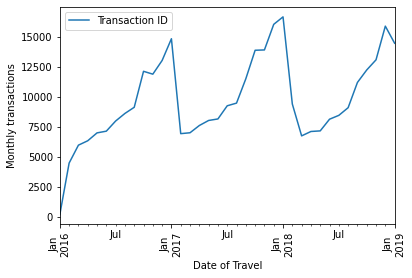

In [6]:
from matplotlib import pyplot as plt

(master
    .set_index("Date of Travel")
    .groupby(pd.Grouper(freq="M"))
    .count()
    .plot(y="Transaction ID")
)
plt.xticks(rotation='vertical')
plt.ylabel("Monthly transactions")
plt.title("")
plt.show()

A clear seasonality can be appreciated. This will contribute to an hypothesis later. For now, let's move on with the next field:

### Company
This is clearly a categorical field, so let's check which categories are present.

In [7]:
master["Company"].unique()

array(['Pink Cab', 'Yellow Cab'], dtype=object)

Two quick observations from this line:
- There are only two companies: "Pink Cab" and "Yellow Cab".
- There is no missing data, since we know that every entry is filled with either "Pink Cab" or "Yellow Cab" (i.e., there are no values with "missing", "error" or similar).

Lastly for this field let's check how do these two companies compare in amount of trips:

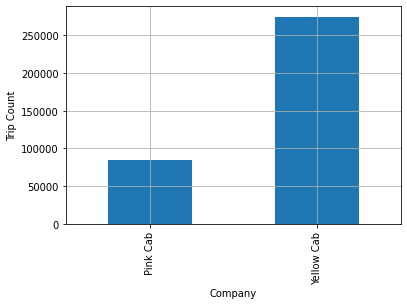

In [8]:
(master.set_index("Date of Travel")
    .groupby("Company")
    .count()
    .plot.bar(y="Transaction ID", legend=False, grid=True))
plt.ylabel("Trip Count")
plt.show()

For this time period, "Yellow Cab" has had around 3 times as many transactions as "Pink Cab". Take into account that that doesn't mean that they made 3 times as much money, for example, since other factors such as the margin or the distance of the trips might influence the profit.

This will form an hypothesis later: we need to thoroughly compare each company in other reasonable ways and speculate about which firm would be a better investment.

### City
Another categorical field. Let's see its possible values:

In [9]:
master["City"].unique()

array(['ATLANTA GA', 'AUSTIN TX', 'BOSTON MA', 'CHICAGO IL', 'DALLAS TX',
       'DENVER CO', 'LOS ANGELES CA', 'MIAMI FL', 'NASHVILLE TN',
       'NEW YORK NY', 'ORANGE COUNTY', 'PHOENIX AZ', 'PITTSBURGH PA',
       'SACRAMENTO CA', 'SAN DIEGO CA', 'SEATTLE WA', 'SILICON VALLEY',
       'TUCSON AZ', 'WASHINGTON DC'], dtype=object)

Just like with companies, every entry seems to be a proper city. If one wanted to process this field they should be careful, though, since the formats vary: e.g. ```SILICON VALLEY``` has two words but no state or ```NEW YORK NY``` has three words (with state).
Let's see how many transactions there are per city:

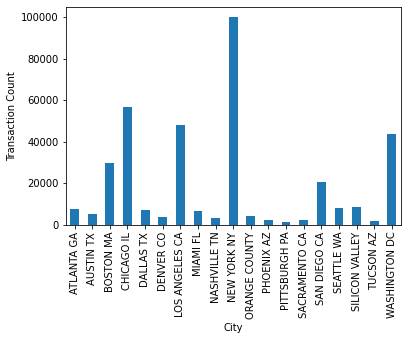

In [10]:
(master.groupby("City")
    .count()
    .Age
    .rename("Transaction Count")
    .plot.bar(y="Transaction Count"))
plt.ylabel("Transaction Count")
plt.show()

The dominant cities/areas are New York, Chicago, LA and Washington. These are also the most populated cities in the USA: the dataset is asking us to compare these transactions with the population of the cities. We will save this for the hypothesis.

### KM Travelled
This is a straightforward numerical value. Let's see what is its distribution: 

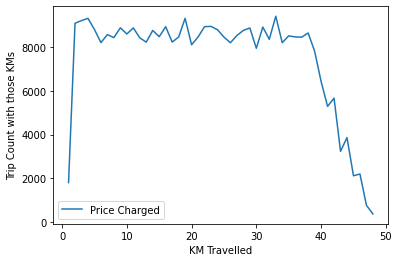

In [11]:
rounded_kms = pd.DataFrame(master[["KM Travelled", "Price Charged"]]).astype(int)
(rounded_kms.groupby("KM Travelled")
    .count()
    .plot(y="Price Charged"))
plt.ylabel("Trip Count with those KMs")
plt.show()

A pretty uniform distribution, perhaps with a slight bump in trips less than 5km and a linear looking decay from 40 to 50 km. Apparently not a single transaction over 50km has been recorded in this database.

### Price Charged and Cost of Trip
These are twin values. Let's check their distribution:

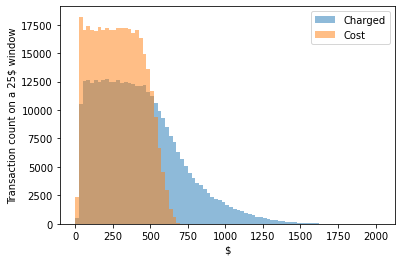

In [12]:
charged = master["Price Charged"]
cost = master["Cost of Trip"]
bins = list(range(0, int(charged.max()), 25))
plt.hist(charged, alpha = 0.5, bins=bins, label="Charged")
plt.hist(cost, alpha = 0.5, bins=bins, label="Cost")
plt.xlabel("$")
plt.ylabel("Transaction count on a 25$ window")
plt.legend()
plt.show()

The charged prices have a higher distribution of values than the cost prices, as expected. Notice, though, that one distribution is not just a translated version of the other. This indicates that the profit margin is variable with the cost.

Talking about margin, that is an interesting field to consider. Let's include it in the database and see how it relates, for example, to the travelled km:

In [13]:
master["Profit"] = charged - cost
lowest = int(master["Profit"].min())
highest = int(master["Profit"].max())
print(f'Range of the margin: [{lowest}$ to {highest}$]')

Range of the margin: [-220$ to 1463$]


It seems that for some trips there have been losses (negative profit). Let's see what kind of distribution the profit has:

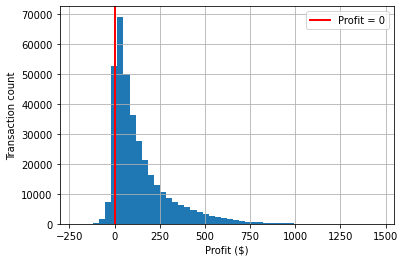

In [14]:
master["Profit"].hist(bins=50)
plt.axvline(0, color="red", linewidth=2,label="Profit = 0")
plt.ylabel("Transaction count")
plt.xlabel("Profit ($)")
plt.legend()
plt.show()

As we can see, most of the points have a positive profit, but there is still a lot of points where are losses. Finally, let's check what's the proportion between these points.

In [15]:
total_transactions = master["Profit"].count()
losses_transactions = master["Profit"].loc[master["Profit"] < 0].count()
f"Percentage of trips with losses: {(100 * losses_transactions) // total_transactions}%"

'Percentage of trips with losses: 6%'

In [16]:
# Saving the master data
master.to_csv("datasets/master_data.csv")

# Hypothesis

The following are some hypothesis I want to test. Some of them appeared naturally while exploring the data ("Some cities have more transactions than the average even after taking its population into account") and some others feel interesting by themselves ("One of the two companies is growing faster than the other").

1. Seasonality is present in the average trip's profit.
2. Seasonality is present in the length of the trips.
3. One of the two companies is growing faster than the other.
4. One of the two companies has more profit per trip than the other.
5. Some cities have more transactions than the average even after taking its population into account.
6. At least some cities are dominated by either company. 

## H1: Seasonality is present in the average trip's profit.
To test this out, I will average profit by day and see how it evolves.

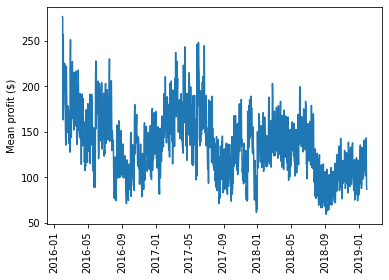

In [17]:
profit_time_series = master[["Profit"]].set_index(master["Date of Travel"])
daily_mean = profit_time_series.groupby(pd.Grouper(freq="D")).mean()
plt.plot(daily_mean.index, daily_mean["Profit"])
plt.xticks(rotation='vertical')
plt.ylabel("Mean profit ($)")
plt.show()

Too grainy. Let's try again grouping by month instead. Let's also plot how many transactions were there in each month, see if there is some correlation:

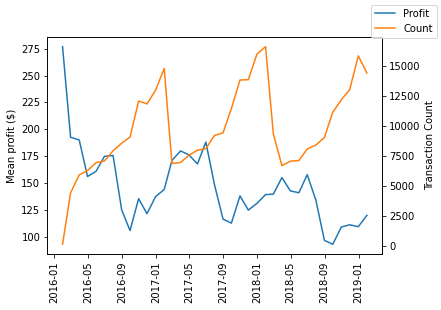

In [18]:
monthly_mean = profit_time_series.groupby(pd.Grouper(freq="M")).mean()
monthly_count = profit_time_series.groupby(pd.Grouper(freq="M")).count()

fig, ax1 = plt.subplots()

ax1.set_ylabel('Mean profit ($)',)
ax1.plot(monthly_mean.index, monthly_mean["Profit"], label="Profit", color="C0")
ax1.tick_params(axis="x", rotation=90)

ax2 = ax1.twinx()

ax2.set_ylabel('Transaction Count')
ax2.plot(monthly_count.index, monthly_count["Profit"], label="Count", color="C1")

fig.legend()
plt.show()

Side by side with the amount of transactions, it seems like the Law of Demand is at work here. **There is indeed a seasonality: when the demand starts increasing -i.e., transactions start raising around August-, the profit of the individual cab trips starts decreasing**.

## H2: Seasonality is present in the length of the trips.
Another way to ask this is: is there a shift between inter and intra city trips between seasons? Again, let's do a monthly average and check it out.

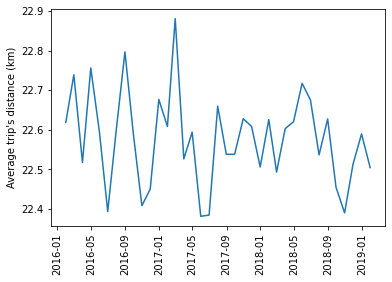

In [19]:
kms = master[["KM Travelled"]].set_index(master["Date of Travel"])
daily_mean_kms = kms.groupby(pd.Grouper(freq="M")).mean()

plt.plot(daily_mean_kms.index, daily_mean_kms["KM Travelled"])
plt.xticks(rotation='vertical')
plt.ylabel("Average trip's distance (km)")
plt.show()

If there is seasonality here, its effect would be less than half a kilometre in the average. To gain perspective, let's just replot this in a 5 km interval:

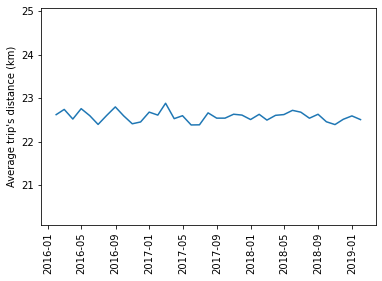

In [20]:
plt.plot(daily_mean_kms.index, daily_mean_kms["KM Travelled"])
plt.xticks(rotation='vertical')
plt.ylabel("Average trip's distance (km)")
center = daily_mean_kms["KM Travelled"].mean()
plt.ylim(center-2.5, center+2.5)
plt.show()

The average trip's distance seems to be pretty flat overall: **there is no relevant seasonality in the average trip's distance**.

## H3: One of the two companies is growing faster than the other.

Yellow Cab has had about three times more transactions than Pink Cab for the last three years. However, we don't know yet how these two companies have evolved in this time. It would be illustrative to plot the amount of transactions and the profit with respect to time. 

From the previous hypothesis it seems that grouping by month gives us the best granularity. Let's start with the profit of both companies:

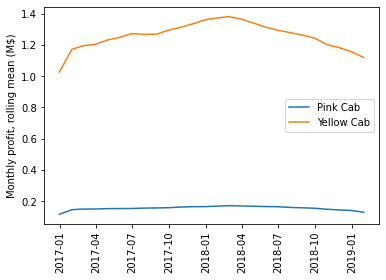

In [21]:
mean_profit_pink = (master[master["Company"] == "Pink Cab"]
                       .set_index("Date of Travel")
                       ["Profit"]
                       .groupby(pd.Grouper(freq="M"))
                       .sum()
                       .rolling(12).mean())

mean_profit_yellow = (master[master["Company"] == "Yellow Cab"]
                         .set_index("Date of Travel")
                         ["Profit"]
                         .groupby(pd.Grouper(freq="M"))
                         .sum()
                         .rolling(12).mean())

plt.plot(mean_profit_pink / 1e6, label="Pink Cab")
plt.plot(mean_profit_yellow / 1e6, label="Yellow Cab")
plt.ylabel("Monthly profit, rolling mean (M$)")
plt.xticks(rotation="vertical")
plt.legend()
plt.show()

Both describe an almost completely seasonal pattern, and neither or them have a clearly growing or decaying trend. Curiously, while both have a peak of profit around January, Yellow Cab also has a peak in the middle of the summer.

Before drawing any conclusions, let's check the evolution of the amount of trips provided by each company.

In [23]:
monthly_count_pink = (master[master["Company"] == "Pink Cab"]
                          ["Company"]
                          .groupby(pd.Grouper(freq="M"))
                          .count())

monthly_count_yellow = (master[master["Company"] == "Pink Cab"]
                            ["Profit"]
                            .groupby(pd.Grouper(freq="M"))
                            .count())

plt.plot(time, monthly_count_pink, label="Pink Cab")
plt.plot(time, monthly_count_yellow, label="Yellow Cab")
plt.ylabel("Trip Count")
plt.xticks(rotation="vertical")
plt.legend()
plt.show()

NameError: name 'trips_pink' is not defined

Again, a very seasonal graph with no clear decay or increase in the trend.

Pink Cab shows to have overall a fraction of the profit and amount of trips of Yellow Cab for most of the year. The difference is even bigger around the summer, when **Yellow Cab is able to make profit when their transactions are relatively low**.

In any case, the trend of both companies is quite stable, so **the companies aren't growing with respect to each other; there isn't a clear trend in neither of them**.

## H4: One of the two companies has more profit per trip than the other.
AKA Is one of the companies more efficient? We will check by taking both mean and median over the trip's profits by company. The reason to take the median is to reduce the impact that scarce, but very expensive, trips have on the mean. 

In [ ]:
master.groupby("Company").median().plot.bar(y="Profit")
plt.ylabel("Median profit per trip ($)")

master.groupby("Company").mean().plot.bar(y="Profit")
plt.ylabel("Mean profit per trip ($)")
plt.show()

**Both in mean and in median, Yellow Cab's profit per trip is more than twice than Pink Cab's**.

## H5: Some cities have more transactions than the average even after taking its population into account.

As we saw when exploring the database, the cities with most transactions were also the most populated ones. But how much does the average man use this cab services? Is it more popular in smaller or bigger cities?

To check this out, I will define the number of transactions per person and year, and see how it compares among cities.

In [ ]:
transactions_by_city = pd.merge(master.groupby("City")["Age"].count().rename("trips"),
                                master.groupby("City")["Population"].min(),
                                on="City")
factor =  365.25 / (master["Date of Travel"].max() - master["Date of Travel"].min()).days

transactions_by_city["Trips per capita"] = factor * transactions_by_city.trips / transactions_by_city.Population
transactions_by_city = transactions_by_city.sort_values(by="Trips per capita", ascending=False)

transactions_by_city.plot.bar(y="Trips per capita", legend=False)
plt.ylabel("Trips per year and person")
plt.show()

Boston and Washington are the clear leaders, having over thrice the amount of trips per year and person than Los Angeles, the next biggest one. **The average person in Boston and Washington uses this services more than three times than the average person in any other city**.

## H6: At least some cities are dominated by either company.
Are both Pink Cab and Yellow Cab present in every city? Is either of them present only in the west coast, for example? Let's see the proportion of trips that each company has in each city.

In [ ]:
trips_city_company = (master.groupby(["City", "Company"])["Age"]
                          .count()
                          .rename("Trips"))
trips_city_company = pd.DataFrame(trips_city_company)

trips_city = trips_city_company.groupby("City").sum()
trips_city_company["Proportions"] = trips_city_company / trips_city

trips_city_company["Proportions"].unstack().plot.bar(stacked=True)
plt.ylabel("Fraction of Trips")
plt.show()

We can see how Yellow Cab holds a greater fraction of the trips in most cities: Nashville is the city with the highest Pink Cab's share, where it holds 60%.

Most importantly, **Yellow Cab dominates (>80% share) in New York, Washington and Chicago, the three cities with most trips**.

# Appendix: Seasonal and trend split
In this EDA I have described time series as being "highly seasonal", but haven't provided a proper decomposition. In broad terms, an additive decomposition models a time series as the sum of four components: **mean value, trend, seasonal component and noise**.

The separation of these components is quite illuminating, since, for example, we can distinguish a seasonal increase of profit in January from a "genuine" growth of the firm, which would be reflected in the trend.

So when I say the profit is highly seasonal what I mean is that most of the variance in the profit series is given by the seasonal term.

Now, I will make use of the ```seasonal_decompose``` from statsmodel. It is a very convenient tool which automatically divides the series in its components.

(```seasonal_decompose``` combines the mean and trend terms when performing the decomposition, hence the manual substraction of the mean profit)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
profit_series = (master.set_index("Date of Travel")
                       .groupby(pd.Grouper(freq="M"))
                       .sum()
                       ["Profit"]/1e6)

mean_profit = profit_series.mean()
            
components = seasonal_decompose(profit_series - mean_profit, period=12, model="additive")
plt.plot(components.trend, label="Trend")
plt.plot(components.seasonal, label="Seasonal")
plt.plot(profit_series*0 + mean_profit, label="Mean profit")
plt.plot(components.resid, label="Noise")
plt.ylabel("Monthly profit (M$)")
plt.xticks(rotation="vertical")
plt.legend(loc="upper right")
plt.show()

As expected, most of the variance is brought by the seasonal component. The mean profit is quite higher than any of the components, which speaks well of the stability of the market. The noise is relatively low, and doesn't seem to have correlation with the other components, which would be worrying.

Finally, the trend seems to go up after the first year and down after the second. With the information that this plot gives us, we cannot be sure if it is a decreasing trend or a yearly fluctuation.